In [1]:
%cd /home/aditya/Documents/SolarCycleProject/code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian
import src.preprocesser as pre
import src.network as network
import src.plotter as plotter 
from src.hyperparams import *
%load_ext autoreload

/home/aditya/Documents/SolarCycleProject/code


Using TensorFlow backend.


In [10]:
%autoreload

In [11]:
# Getting the data
headers = ["Year",
           "Month",
           "Day",
           "Decimal Date",
           "Daily Total Sunspot Number",
           "Sunspot Number Stddev",
           "No of observations",
           "Definitive/Provisional"
]
filename = "data/SN_d_tot_V2.0.csv"
data = pd.read_csv(filename, delimiter=";", names=headers)[:1000]

In [12]:
data

,Year,Month,Day,Decimal Date,Daily Total Sunspot Number,Sunspot Number Stddev,No of observations,Definitive/Provisional
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
995,1820,9,22,1820.725,-1,-1.0,0,1
996,1820,9,23,1820.728,25,6.3,1,1
997,1820,9,24,1820.731,-1,-1.0,0,1
998,1820,9,25,1820.734,0,2.0,1,1


In [13]:
# Data Preprocessing
dates, spots, inverter = pre.preprocess(data)

[27.6  28.   27.   27.   26.25 25.75 25.   12.5   0.    0.  ]
ymax: 202.0 ymin: 0.0
x.shape: (993,)
y.shape: (993,)
y values scaler: 101.0


In [14]:
if mean_type == "gaussian":
    weights = gaussian(M=mean_length, std=0.1, sym=True)
    weights /= np.sum(weights) # normalise the weights
    spots = pre.running_mean_helper(spots, weights)
elif mean_type == "uniform":
    weights = np.ones(mean_length)/mean_length
    spots = pre.running_mean_helper(spots, weights)
else:
    pass


In [15]:
X = spots
index = dates
x_slid, y_slid, idx_slid = pre.sliding_window_main(X, X, index)
x_train, y_train, idx_train, x_val, y_val, idx_val, x_test, y_test, idx_test = pre.data_splitting_main(x_slid, y_slid, idx_slid)

x_slid.shape: (991, 2, 1)
y_slid.shape: (991, 1)
x_train.shape:  (594, 2, 1)
y_train.shape:  (594, 1)
idx_train.shape:  (594,)
x_val.shape:  (198, 2, 1)
y_val.shape:  (198, 1)
idx_val.shape:  (198,)
x_test.shape:  (199, 2, 1)
y_test.shape:  (199, 1)
idx_test.shape:  (199,)



In [16]:
net = network.create_network()

In [17]:
history = network.trainer(net, x_train, y_train, x_val, y_val, verbose=1)
var_train = np.var(y_train)
var_val = np.var(y_val)
print("Variance in y_train:", var_train)
print("Variance in y_val:", var_val)

Train on 594 samples, validate on 198 samples
Epoch 1/20
594/594 [==============================] - 3s 5ms/step - loss: 0.0513 - val_loss: 0.0306
Epoch 2/20
594/594 [==============================] - 2s 4ms/step - loss: 0.0383 - val_loss: 0.0281
Epoch 3/20
594/594 [==============================] - 2s 4ms/step - loss: 0.0360 - val_loss: 0.0264
Epoch 4/20
594/594 [==============================] - 2s 4ms/step - loss: 0.0337 - val_loss: 0.0249
Epoch 5/20
594/594 [==============================] - 2s 4ms/step - loss: 0.0315 - val_loss: 0.0240
Epoch 6/20
594/594 [==============================] - 3s 4ms/step - loss: 0.0303 - val_loss: 0.0236
Epoch 7/20
594/594 [==============================] - 2s 4ms/step - loss: 0.0300 - val_loss: 0.0235
Epoch 8/20
594/594 [==============================] - 2s 4ms/step - loss: 0.0300 - val_loss: 0.0234
Epoch 9/20
594/594 [==============================] - 2s 4ms/step - loss: 0.0299 - val_loss: 0.0233
Epoch 10/20
594/594 [==============================] -

pred1.shape: (198, 1)
pred2.shape: (594, 1)


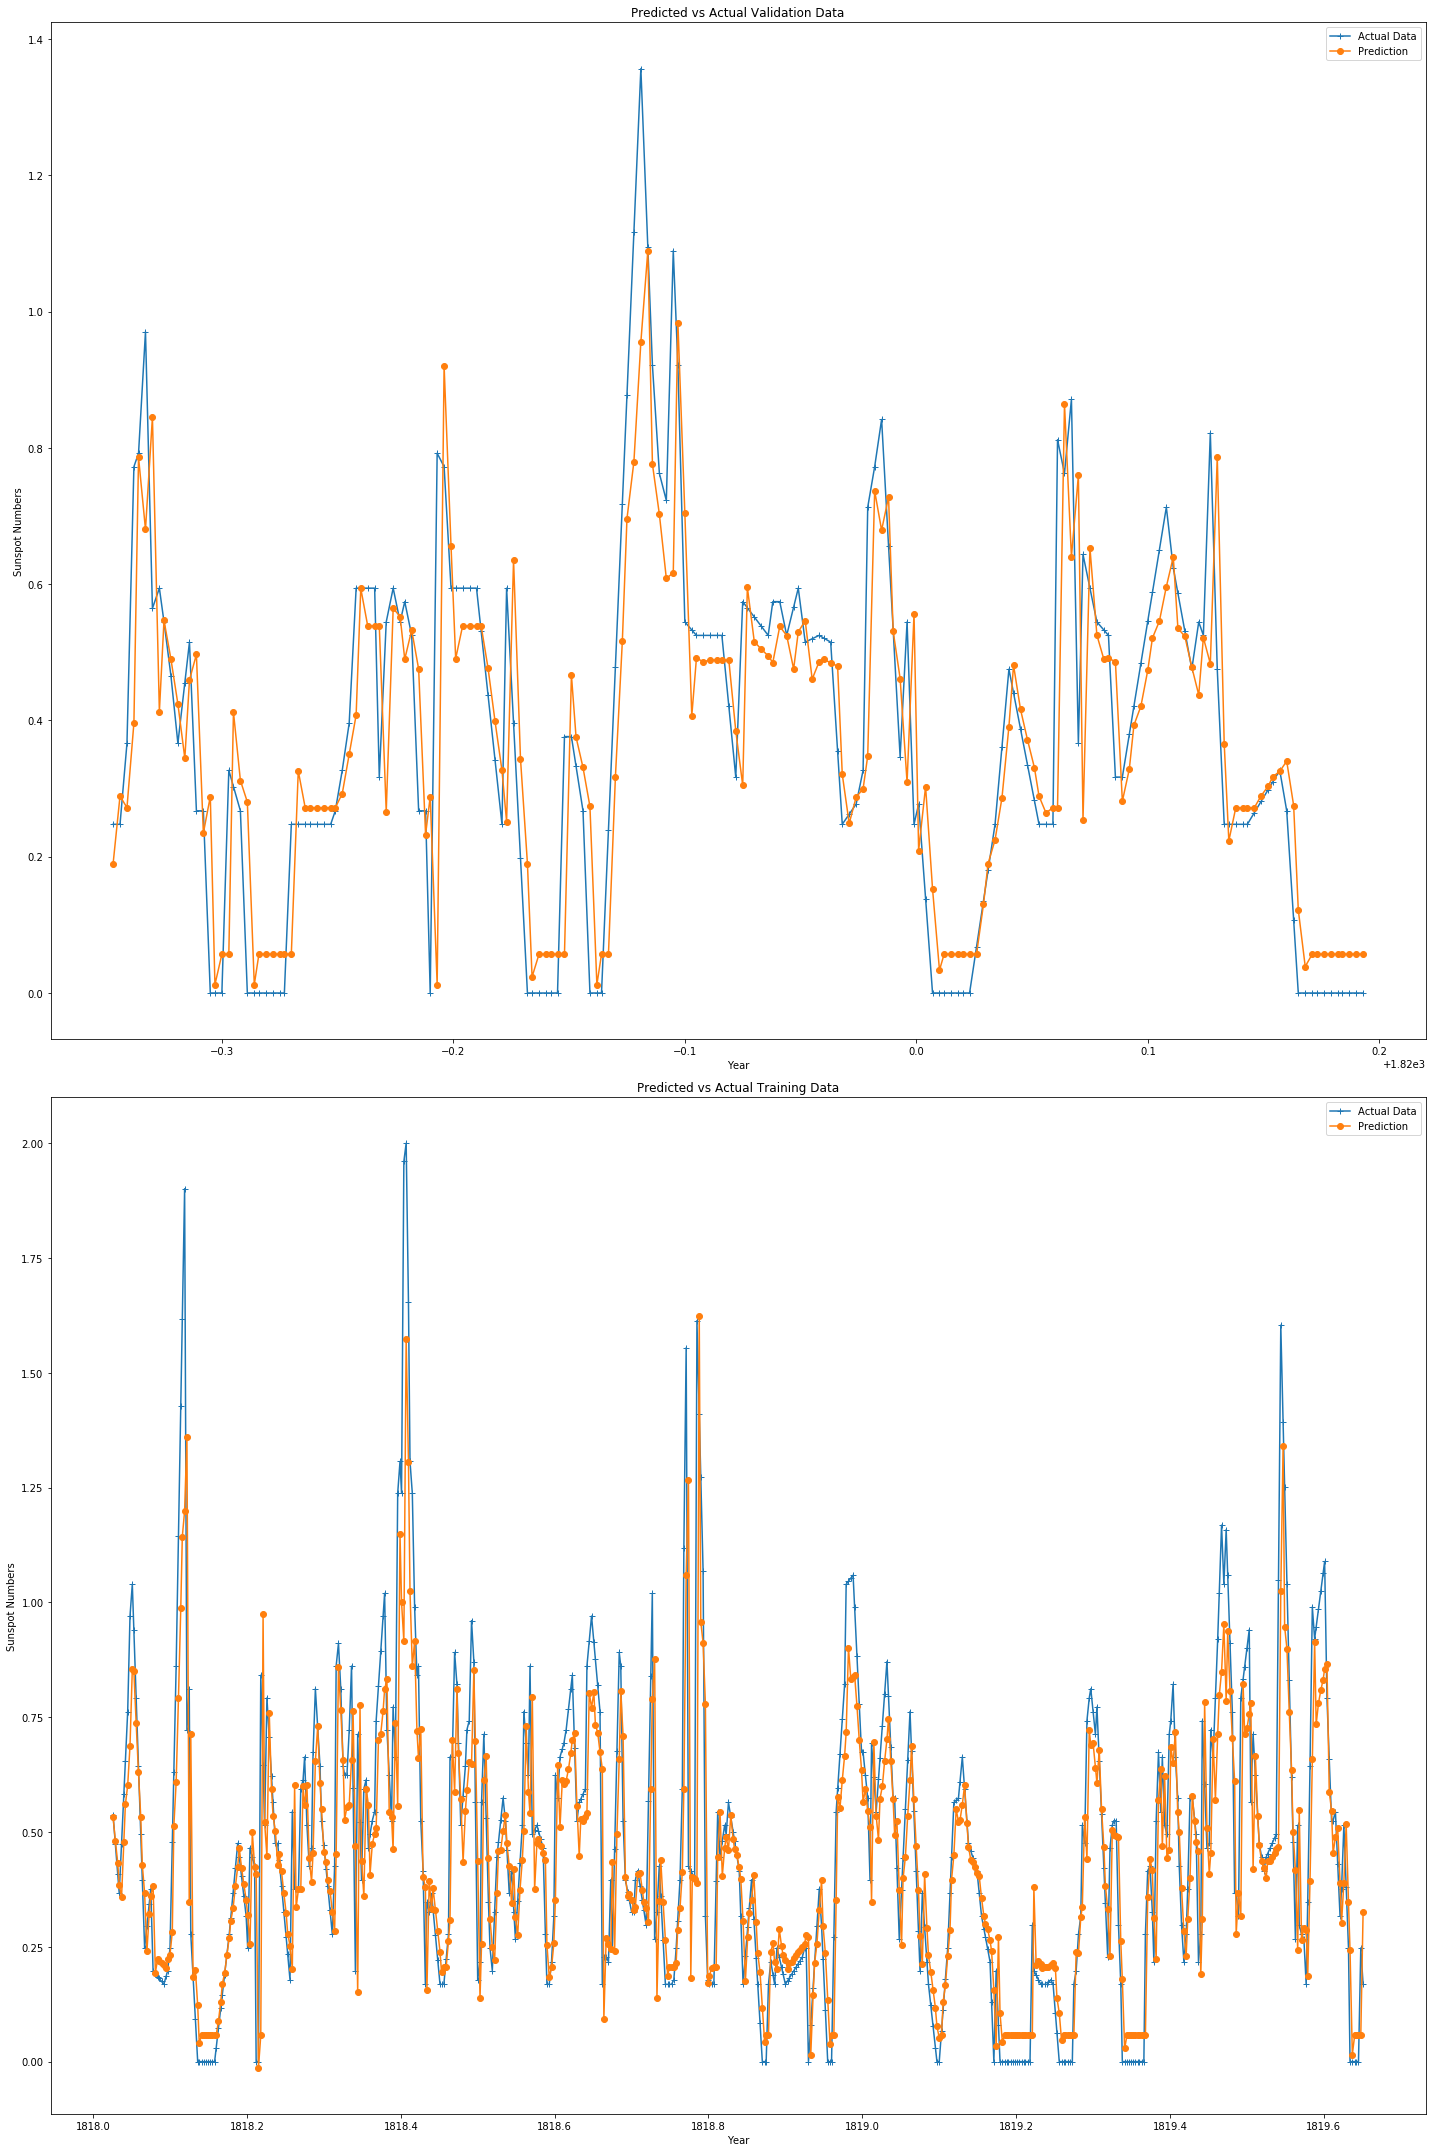

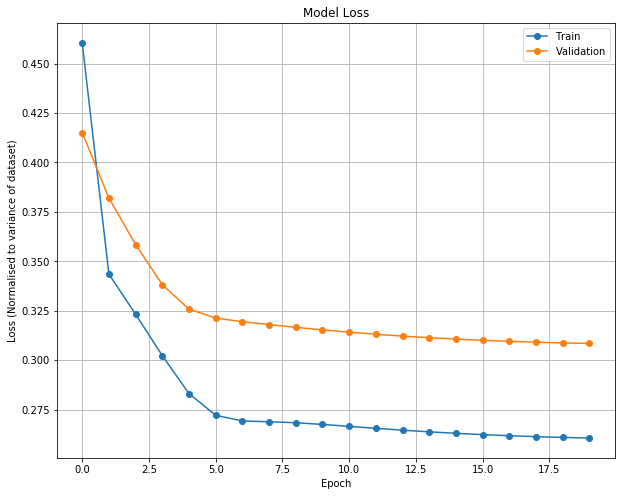

In [18]:
plotter.plot_predictions(net, x_train, y_train, idx_train, x_val, y_val, idx_val)
plotter.plot_loss_vs_epoch(history, var_train, var_val)